In [37]:
import sys
import os
import time
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshcat.geometry as g
import meshcat.transformations as tf
plt.style.use('seaborn-v0_8')

# Add the bsqp interface to path
sys.path.append('./build/python')

from bsqp.interface import BSQP
from force_estimator import ImprovedForceEstimator

np.set_printoptions(linewidth=99999999)
np.random.seed(42)

urdf_path = "iiwa_description/iiwa14.urdf"
model_dir = "iiwa_description/"

class MPC_GATO:
    def __init__(self, model, N, dt, batch_size, pendulum_mass=0.0, pendulum_length=0.3, pendulum_damping=0.4):
        # Store original model for solver (without pendulum)
        self.solver_model = model
        self.pendulum_mass = pendulum_mass
        self.pendulum_length = pendulum_length
        self.pendulum_damping = pendulum_damping
        
        # Create augmented model for simulation (with pendulum)
        self.model = self.add_pendulum_to_model(model.copy())
        self.model.gravity.linear = np.array([0, 0, -9.81])
        self.data = self.model.createData()
        
        self.solver = BSQP(
            model_path=urdf_path,
            batch_size=batch_size,
            N=N,
            dt=dt,
            kkt_tol=0.0,
            max_sqp_iters=1,
            max_pcg_iters=200,
            pcg_tol=1e-5,
            solve_ratio=1.0,
            mu=10.0,
            q_cost=0.3,
            u_cost=1e-6,
            N_cost=2.0,
            qd_cost=4e-2,
            q_lim_cost=0.00,
            vel_lim_cost=0.01,
            ctrl_lim_cost=0.0,
            rho=1e-3
        )
        
        self.q_traj = []  # trajectory for visualization (robot only)
        self.q_traj_full = []  # full trajectory including pendulum
        
        # Dimensions - note model has extra DOFs from pendulum
        self.nq_robot = self.solver_model.nq
        self.nv_robot = self.solver_model.nv
        self.nq = self.model.nq  # Robot + pendulum
        self.nv = self.model.nv  # Robot + pendulum
        self.nx = self.nq_robot + self.nv_robot  # Solver state dimension (robot only)
        self.nu = self.solver_model.nv  # Control dimension (robot only)
        self.N = N
        self.dt = dt
        self.batch_size = batch_size
        
        self.q_limits = np.array([
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-3.05433,  3.05433],
        ])
        self.qd_limits = np.array([
            [-1.48353,  1.48353],
            [-1.48353,  1.48353],
            [-1.74533,  1.74533],
            [-1.30900,  1.30900],
            [-2.26893,  2.26893],
            [-2.35619,  2.35619],
            [-2.35619,  2.35619],
        ])
        self.u_limits = np.array([
            [-320.0, 320.0],
            [-320.0, 320.0],
            [-176.0, 176.0],
            [-176.0, 176.0],
            [-110.0, 110.0],
            [ -40.0,  40.0],
            [ -40.0,  40.0],
        ])
        
        if batch_size > 1:
            self.force_estimator = ImprovedForceEstimator(
                batch_size=batch_size,
                initial_radius=5.0,  
                min_radius=1.0,
                max_radius=20.0,     
                smoothing_factor=0.5 
            )
            self.current_force_batch = None
        else:
            self.force_estimator = None
            self.current_force_batch = None
        
        self.actual_f_ext = pin.StdVec_Force()
        for _ in range(self.model.njoints):
            self.actual_f_ext.append(pin.Force.Zero())
    
    def add_pendulum_to_model(self, model):
        """Add a 3D pendulum (spherical joint) to the end-effector."""
        ee_joint_id = model.njoints - 1  # Last joint is EE
        pendulum_joint_id = model.addJoint(ee_joint_id,pin.JointModelSpherical(),pin.SE3.Identity(),"pendulum_joint") # Spherical joint for pendulum
        
        # Create inertia for pendulum bob (point mass at distance)
        com = np.array([0.0, 0.0, -self.pendulum_length])  # Center of mass along -Z
        inertia_matrix = np.diag([0.001, 0.001, 0.001])  # Small inertia at COM
        pendulum_inertia = pin.Inertia(self.pendulum_mass, com, inertia_matrix)
        model.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

        return model
    
    def transform_force_to_gato_frame(self, q, f_world):
        """
        Transform a force from world frame at end-effector to local frame at joint 5.
        Uses only robot joints (first nq_robot elements of q).
        """
        # Create data for solver model to do kinematics
        solver_data = self.solver_model.createData()
        
        # Use only robot configuration
        q_robot = q[:self.nq_robot]
        
        # Update kinematics on solver model
        pin.forwardKinematics(self.solver_model, solver_data, q_robot)
        pin.updateFramePlacements(self.solver_model, solver_data)
        
        # Joint indices
        jid_ee_fin = self.solver_model.getFrameId("EE") # End-effector Frame Reference
        jid_ee_pin = self.solver_model.frames[jid_ee_fin].parentJoint # End-effector joint
        jid_eep_pin = jid_ee_pin - 1 # End-effector parent joint

        # Get transformations
        transform_world_to_ee = solver_data.oMi[jid_ee_pin]
        transform_world_to_jeep = solver_data.oMi[jid_eep_pin]
        
        # Compute transformation from End-Effector parent to child joints
        transform_jeep_to_ee = transform_world_to_jeep.inverse() * transform_world_to_ee

        # Create force at end-effector in world frame
        force_ee_world = pin.Force(f_world[:3], f_world[3:])
        
        # Transform to Joint 5 local frame
        force_ee_local = transform_world_to_ee.actInv(force_ee_world)
        wrench_jeep_local = transform_jeep_to_ee.actInv(force_ee_local)

        result = np.zeros(6)
        result[:3] = wrench_jeep_local.linear
        result[3:] = wrench_jeep_local.angular

        return result

    def check_limits(self, t, q_robot, dq_robot, u_robot=None):
        """Check joint position, velocity, and control limits and print/log any violations.
        Returns a dict of violations (empty if none).
        """
        viol = {}
        # Positions
        qmin, qmax = self.q_limits[:, 0], self.q_limits[:, 1]
        q_low = np.where(q_robot < qmin)[0]
        q_high = np.where(q_robot > qmax)[0]
        if q_low.size or q_high.size:
            viol['q'] = {'low': q_low.tolist(), 'high': q_high.tolist(), 'vals': q_robot[(list(q_low)+list(q_high))].tolist()}
            idxs = list(q_low) + list(q_high)
            msgs = [f"j{int(i)}={q_robot[int(i)]:.3f} in [{qmin[int(i)]:.3f},{qmax[int(i)]:.3f}]" for i in idxs]
            print(f"[LIMIT][q ] t={t:6.3f}s -> {'; '.join(msgs)}")
        # Velocities
        vmin, vmax = self.qd_limits[:, 0], self.qd_limits[:, 1]
        v_low = np.where(dq_robot < vmin)[0]
        v_high = np.where(dq_robot > vmax)[0]
        if v_low.size or v_high.size:
            viol['qd'] = {'low': v_low.tolist(), 'high': v_high.tolist(), 'vals': dq_robot[(list(v_low)+list(v_high))].tolist()}
            idxs = list(v_low) + list(v_high)
            msgs = [f"j{int(i)}={dq_robot[int(i)]:.3f} in [{vmin[int(i)]:.3f},{vmax[int(i)]:.3f}]" for i in idxs]
            print(f"[LIMIT][qd] t={t:6.3f}s -> {'; '.join(msgs)}")
        # Controls
        if u_robot is not None:
            umin, umax = self.u_limits[:, 0], self.u_limits[:, 1]
            u_low = np.where(u_robot < umin)[0]
            u_high = np.where(u_robot > umax)[0]
            if u_low.size or u_high.size:
                viol['u'] = {'low': u_low.tolist(), 'high': u_high.tolist(), 'vals': u_robot[(list(u_low)+list(u_high))].tolist()}
                idxs = list(u_low) + list(u_high)
                msgs = [f"j{int(i)}={u_robot[int(i)]:.2f} in [{umin[int(i)]:.2f},{umax[int(i)]:.2f}]" for i in idxs]
                print(f"[LIMIT][u ] t={t:6.3f}s -> {'; '.join(msgs)}")
        return viol
    
    def update_force_batch(self, q):
        
        # No external force hypothesis for single batch
        if self.batch_size == 1:  
            return
        
        self.current_force_batch = self.force_estimator.generate_batch()
        # Transform each force hypothesis to GATO frame
        transformed_batch = np.zeros_like(self.current_force_batch)
        for i in range(self.batch_size):
            # Each hypothesis is in world frame, transform to GATO frame
            transformed_batch[i, :] = self.transform_force_to_gato_frame(q, self.current_force_batch[i, :])
        
        self.solver.set_f_ext_B(transformed_batch)
    
    def evaluate_best_trajectory(self, x_last, u_last, x_curr, dt):
        """Evaluate which trajectory best matches reality (called post-solve)."""
        if self.batch_size == 1:
            return 0
        
        # Simulate all hypotheses with their corresponding forces
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        
        # Calculate errors for all hypotheses
        errors = np.linalg.norm(x_next_batch - x_curr[None, :], axis=1)
        best_id = np.argmin(errors)
        
        # Update estimator with results
        self.force_estimator.update(best_id, errors, alpha=0.4, beta=0.5)
        
        return best_id
                
    def run_mpc(self, x_start, goals, sim_dt=0.001, sim_time=5):        
            
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': [],
            'ee_actual': [],  # Actual end-effector positions
            'ee_velocity': [],  # End-effector velocities
            'controls': [],  # Control inputs (torques)
            'joint_positions': [],  # All joint positions
            'joint_velocities': [],  # All joint velocities
            'timestamps': [],  # Time stamps for each step
            'sqp_iters': [],  # SQP iterations
            'pcg_iters': [],  # PCG iterations
            'force_estimates': [],  # Force estimates (if batch)
            'force_estimates_gato': [],  # Force estimates in GATO frame
            'force_radius': [],  # Force estimator search radius
            'force_confidence': [],  # Force estimator confidence
            'best_trajectory_id': []  # Which trajectory was selected
        }
        
        stats['goal_outcomes_by_idx'] = ['not_reached'] * len(goals)
        
        total_sim_time = 0.0
        steps = 0
        accumulated_time = 0.0
        
        # Initialize augmented state with pendulum at rest
        x_start_aug = np.zeros(self.nq + self.nv)
        x_start_aug[:self.nx] = x_start  # Robot state
        # Pendulum starts with small initial angle
        x_start_aug[self.nq_robot:self.nq_robot+3] = np.array([0.3, 0.0, 0.0])  # Small rotation
        
        q = x_start_aug[:self.nq]
        dq = x_start_aug[self.nq:]
        
        # Solver uses robot-only state
        x_curr = x_start
        x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
        
        # Initialize first goal
        current_goal_idx = 0
        current_goal = goals[current_goal_idx]
        ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
        ee_g_batch = np.tile(ee_g, (self.batch_size, 1))
        
        XU = np.zeros(self.N*(self.nx+self.nu)-self.nu)
        for i in range(self.N):
            start_idx = i * (self.nx + self.nu)
            XU[start_idx:start_idx+self.nx] = x_curr
        self.solver.reset_dual()
        XU_batch = np.tile(XU, (self.batch_size, 1))
        
        # Warm up run with initial force batch
        self.update_force_batch(q)
        solve_start = time.time()
        XU_batch, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
        solve_time = time.time() - solve_start
        XU_best = XU_batch[0, :]
        
        print(f"\n========== Running MPC for {sim_time} seconds with N={self.N} and batch size={self.batch_size} ==========")
        
        # Start timing for the current goal
        goal_start_time = total_sim_time
                
        while total_sim_time < sim_time:
            steps += 1
            
            timestep = solve_time
            
            x_last = x_curr
            u_last = XU_best[self.nx:self.nx+self.nu]
            
            # ----- Step Simulation -----
            
            nsteps = int(timestep/sim_dt)
            for i in range(nsteps):
                offset = int(i/(self.dt/sim_dt))  # get correct control input
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                
                # Augment control with robot torques and viscous damping on pendulum
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                # Apply viscous damping on pendulum (3-DOF spherical joint)
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:]
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            if timestep%sim_dt > 1e-5: 
                accumulated_time += timestep%sim_dt
                
            if accumulated_time - sim_dt > 0.0:
                accumulated_time = 0.0
                
                offset = int(nsteps/(self.dt/sim_dt))
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                
                # Augment control with robot torques and viscous damping on pendulum
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                # Apply viscous damping on pendulum (3-DOF spherical joint)
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:]
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            # Update solver state (robot only)
            x_curr = np.concatenate([q[:self.nq_robot], dq[:self.nv_robot]])
            
            # ----- Optimize trajectory toward current goal -----
            
            current_dist = np.linalg.norm(self.eepos(q[:self.nq_robot]) - current_goal)
            current_vel = np.linalg.norm(dq[:self.nv_robot], ord=1)
            reached = (current_dist < 5e-2) and (current_vel < 1.0)
            timeout = (total_sim_time - goal_start_time) >= 10.0
            if reached or timeout:
                if reached:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'reached'
                    print(f"REACHED Goal {current_goal_idx} at {total_sim_time:4.3f}s")
                else:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'timeout'
                    print(f"TIMEOUT Goal {current_goal_idx} at {total_sim_time:4.3f}s")
                current_goal_idx += 1
                if current_goal_idx >= len(goals):
                    print("All goals processed")
                    break
                current_goal = goals[current_goal_idx]
                ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
                goal_start_time = total_sim_time
            
            x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
            ee_g_batch[:, :] = ee_g
            XU_batch[:, :self.nx] = x_curr
            
            self.update_force_batch(q)
        #     self.solver.solver.reset_rho()
            solve_start = time.time()
            XU_batch_new, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
            solve_time = time.time() - solve_start
            
            best_id = self.evaluate_best_trajectory(x_last, u_last, x_curr, sim_dt)

            XU_best = XU_batch_new[best_id, :]
            XU_batch[:, :] = XU_best
            # -----
            
            ee_pos = self.eepos(q[:self.nq_robot])
            pin.forwardKinematics(self.solver_model, self.solver_model.createData(), q[:self.nq_robot], dq[:self.nv_robot])
            ee_vel = pin.getFrameVelocity(self.solver_model, self.solver_model.createData(), 6, pin.LOCAL_WORLD_ALIGNED).linear
            
            stats['timestamps'].append(total_sim_time)
            stats['solve_times'].append(float(round(gpu_solve_time/1e3, 5)))
            goaldist = np.sqrt(np.sum((ee_pos[:3] - current_goal)**2))
            stats['goal_distances'].append(float(round(goaldist, 5)))
            stats['ee_goal'].append(current_goal.copy())
            stats['ee_actual'].append(ee_pos.copy())
            stats['ee_velocity'].append(ee_vel.copy())
            stats['controls'].append(u_last.copy())
            stats['joint_positions'].append(q[:self.nq_robot].copy())
            stats['joint_velocities'].append(dq[:self.nv_robot].copy())
            stats['best_trajectory_id'].append(best_id)
            
            # Get solver statistics
            solver_stats = self.solver.get_stats()
            
            stats['sqp_iters'].append(solver_stats['sqp_iters'])
            stats['pcg_iters'].append(solver_stats['pcg_iters'][0] if len(solver_stats['pcg_iters']) > 0 else 0)

            # Calculate actual pendulum force reaction for comparison
            pendulum_com_acc = pin.getFrameClassicalAcceleration(self.model, self.data, self.model.njoints-1, pin.LOCAL_WORLD_ALIGNED).linear
            pendulum_mass = 8.0
            pendulum_force = -pendulum_mass * (pendulum_com_acc - self.model.gravity.linear)
        
            stats['force_estimates'].append(np.concatenate([pendulum_force, np.zeros(3)]))
        
            if steps % 2000 == 0:
                # print(dq[:self.nv_robot])
                # print(u_last)
                viol = self.check_limits(total_sim_time, q[:self.nq_robot], dq[:self.nv_robot], u_last)
                # Also print force estimate for monitoring
                if self.force_estimator:
                    est_stats = self.force_estimator.get_stats()
                    smoothed = est_stats['current_estimate']
                    smoothed = self.transform_force_to_gato_frame(q, smoothed)
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | id={best_id} | f_world=[{smoothed[0]:5.1f}, {smoothed[1]:5.1f}, {smoothed[2]:5.1f}] | f_p=[{pendulum_force[0]:5.1f}, {pendulum_force[1]:5.1f}, {pendulum_force[2]:5.1f}] | t={total_sim_time:4.3f}s")
                else:
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | sqp_iters={stats['sqp_iters'][-1]} | t={total_sim_time:4.3f}s")

        print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"avg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"========== MPC finished ==========")
        
        # Convert lists to numpy arrays for easier processing
        for key in stats:
            if stats[key]:
                stats[key] = np.array(stats[key])

        return self.q_traj, stats
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u, self.actual_f_ext)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u, self.actual_f_ext)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u, self.actual_f_ext)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u, self.actual_f_ext)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
            
    def eepos(self, q):
        """Get end-effector position using solver model (robot only)."""
        solver_data = self.solver_model.createData()
        pin.forwardKinematics(self.solver_model, solver_data, q)
        return solver_data.oMi[self.solver_model.njoints - 1].translation

In [38]:
goals = [
        np.array([0.6, -0.1, 0.5]),
        np.array([0.5, 0.3, 0.2]),
        np.array([0.3, 0.3, 0.8]),
        np.array([0.4, -0.5, 0.2]),
        np.array([0., -0.5, 0.8])
]

model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

N = 16
dt = 0.05
sim_dt = 0.001

x_start = np.zeros(model.nq + model.nv)

mpc_1 = MPC_GATO(model, N=N, dt=dt, batch_size=1)
q_trajectory, mpc_stats_1 = mpc_1.run_mpc(x_start, goals, sim_dt=sim_dt, sim_time=30.0)

T : f

========== Running MPC for 30.0 seconds with N=16 and batch size=1 ==========
err=0.763 | qd=1.719 | t_sqp=0.185 ms | sqp_iters=[1] | t=0.355s
err=0.545 | qd=1.353 | t_sqp=0.167 ms | sqp_iters=[1] | t=0.697s
err=0.384 | qd=0.928 | t_sqp=0.166 ms | sqp_iters=[1] | t=1.036s
err=0.292 | qd=0.581 | t_sqp=0.133 ms | sqp_iters=[1] | t=1.379s
err=0.248 | qd=0.379 | t_sqp=0.160 ms | sqp_iters=[1] | t=1.725s
err=0.228 | qd=0.258 | t_sqp=0.175 ms | sqp_iters=[1] | t=2.072s
err=0.217 | qd=0.185 | t_sqp=0.177 ms | sqp_iters=[1] | t=2.419s
err=0.208 | qd=0.168 | t_sqp=0.152 ms | sqp_iters=[1] | t=2.798s
err=0.200 | qd=0.184 | t_sqp=0.178 ms | sqp_iters=[1] | t=3.193s
err=0.193 | qd=0.191 | t_sqp=0.168 ms | sqp_iters=[1] | t=3.577s
err=0.185 | qd=0.189 | t_sqp=0.160 ms | sqp_iters=[1] | t=3.943s
err=0.178 | qd=0.191 | t_sqp=0.160 ms | sqp_iters=[1] | t=4.299s
err=0.171 | qd=0.192 | t_sqp=0.142 ms | sqp_iters=[1] | t=4.648s
err=0.163 | qd=0.191 | t_sqp=0.166 ms | sqp_iters=[1] | t=4.994s
err=0

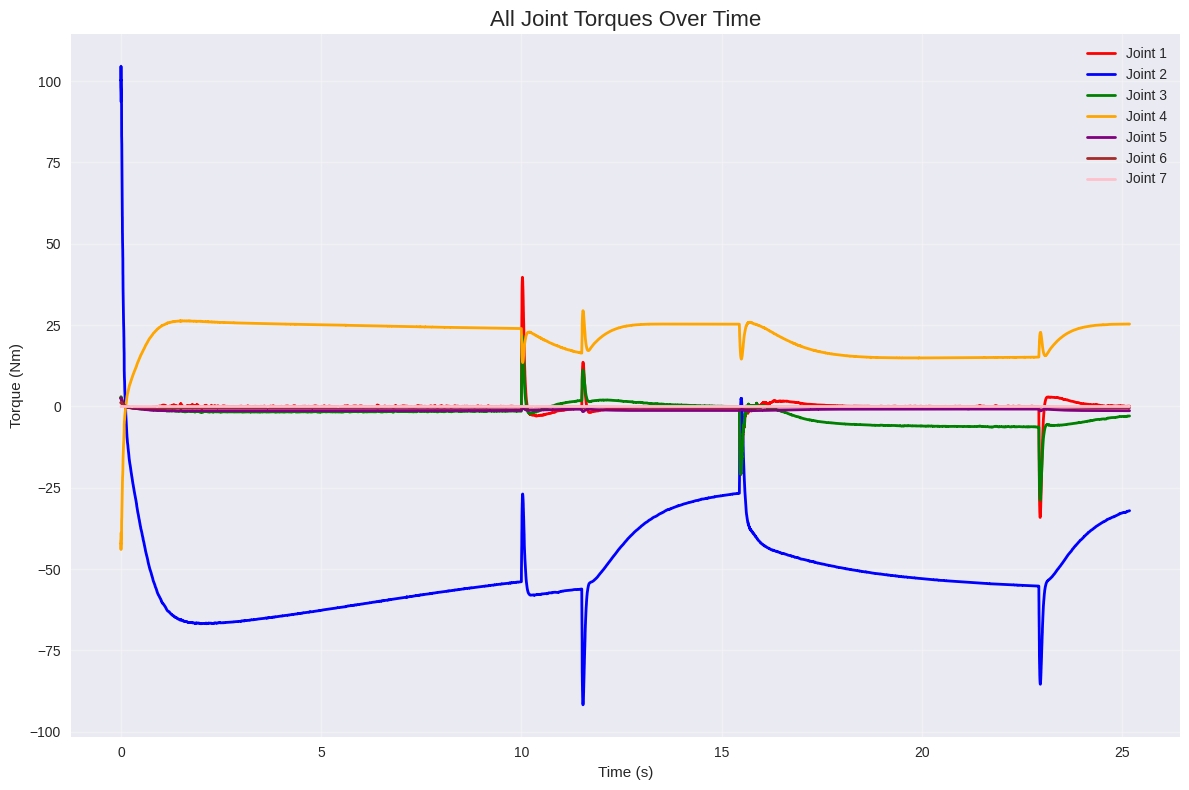

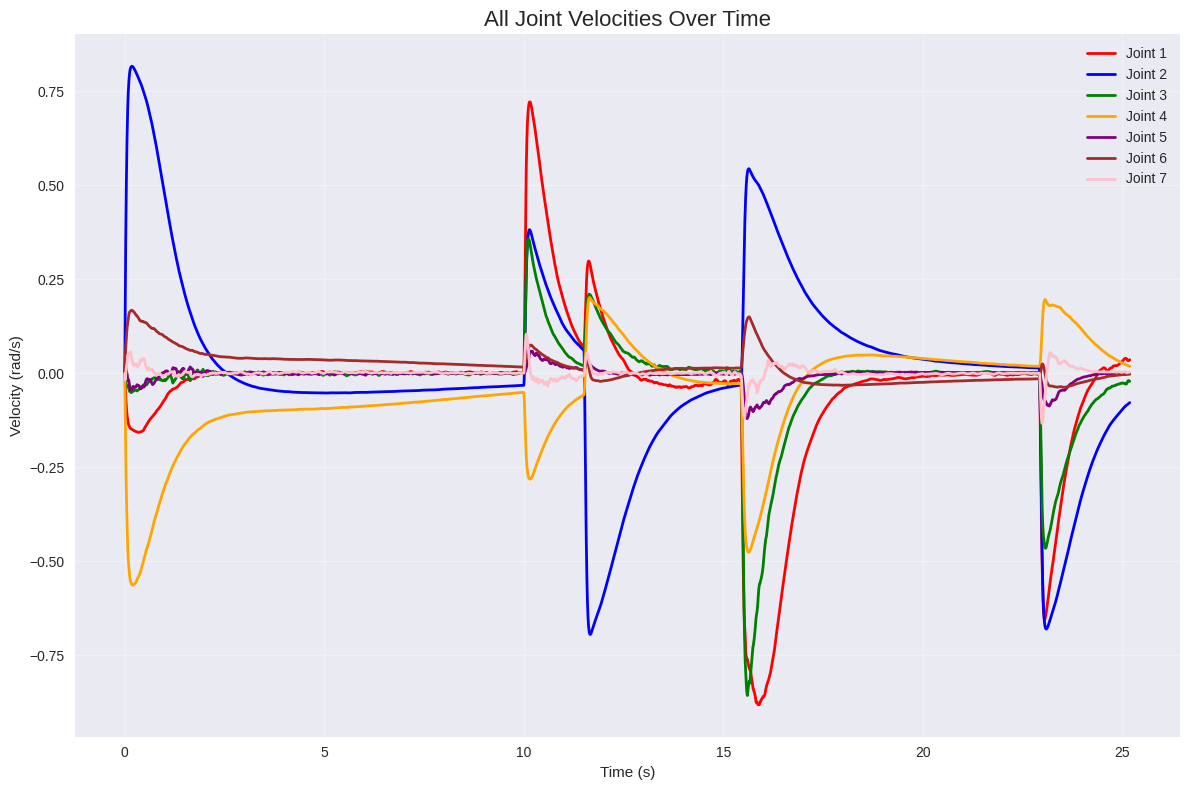

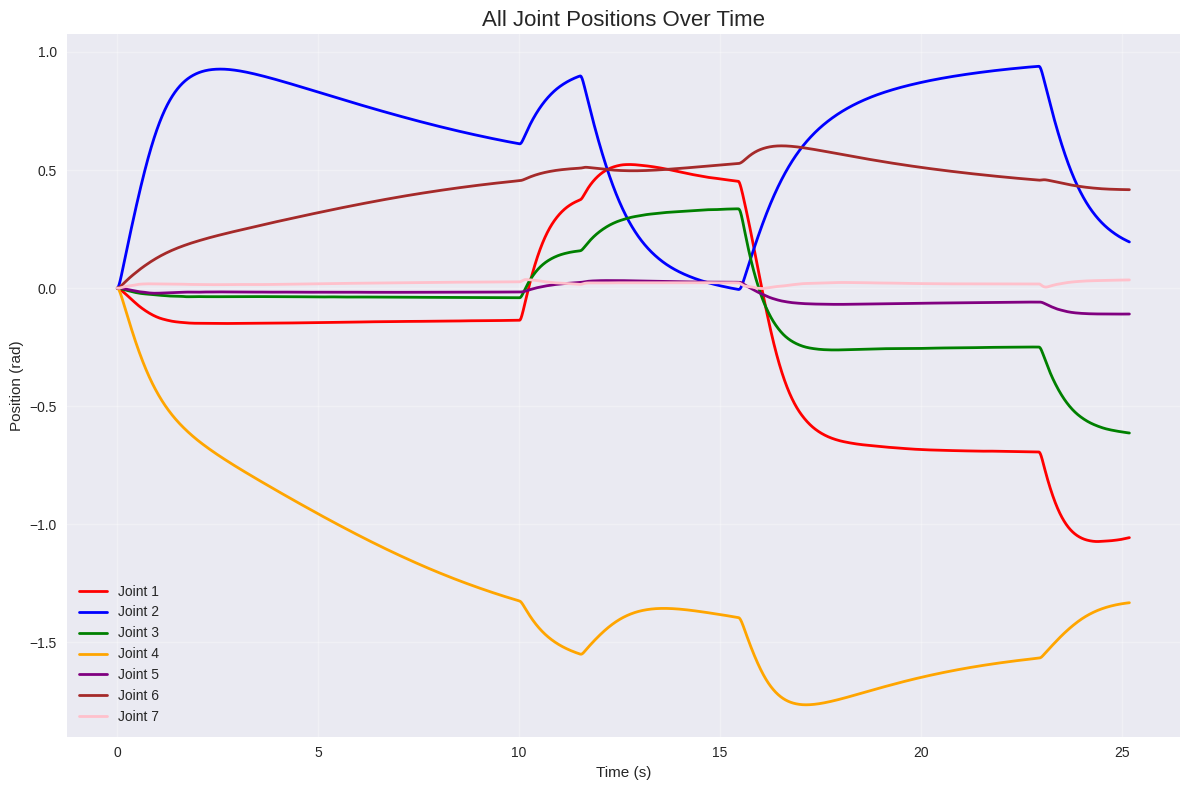

In [39]:
# Plot controls over time
import matplotlib.pyplot as plt

# Get time data and controls
timestamps = np.array(mpc_stats_1['timestamps'])
controls = np.array(mpc_stats_1['controls'])
velocities = np.array(mpc_stats_1['joint_velocities'])
positions = np.array(mpc_stats_1['joint_positions'])

joint_names = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.plot(timestamps, controls[:, i], color=colors[i], linewidth=2, label=joint_names[i])

plt.title('All Joint Torques Over Time', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.plot(timestamps, velocities[:, i], color=colors[i], linewidth=2, label=joint_names[i])

plt.title('All Joint Velocities Over Time', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (rad/s)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
for i in range(7):
    plt.plot(timestamps, positions[:, i], color=colors[i], linewidth=2, label=joint_names[i])

plt.title('All Joint Positions Over Time', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Position (rad)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model_viz, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

# Add pendulum to visualization model
ee_joint_id = model_viz.njoints - 1
pendulum_joint_id = model_viz.addJoint(
    ee_joint_id,
    pin.JointModelSpherical(),
    pin.SE3.Identity(),
    "pendulum_joint"
)
mass = 10.0
length = 0.4
com = np.array([0.0, 0.0, -length])
inertia_matrix = np.diag([0.001, 0.001, 0.001])
pendulum_inertia = pin.Inertia(mass, com, inertia_matrix)
model_viz.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

viz = MeshcatVisualizer(model_viz, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot")


# Pendulum rod
viz.viewer['pendulum_rod'].set_object(
    g.Cylinder(height=length, radius=0.01),
    g.MeshLambertMaterial(color=0x808080)
)

# Pendulum bob
viz.viewer['pendulum_bob'].set_object(
    g.Sphere(0.05),
    g.MeshLambertMaterial(color=0x0000ff)
)

# Default all goals to red (not reached/timeout)
for i, goal in enumerate(goals):
    viz.viewer[f'goal_point_{i}'].set_object(
        g.Sphere(0.02),
        g.MeshLambertMaterial(color=0xff0000)
    )
    T = tf.translation_matrix(np.array(goal))
    viz.viewer[f'goal_point_{i}'].set_transform(T)



# Choose which MPC instance to visualize
# mpc_instance = mpc_32
# goal_outcomes = list(mpc_stats_32['goal_outcomes_by_idx'])

mpc_instance = mpc_1
goal_outcomes = list(mpc_stats_1['goal_outcomes_by_idx'])

q_traj_full = mpc_instance.q_traj_full

# Apply colors based on outcomes: green=reached, red=timeout/not reached
for i, outcome in enumerate(goal_outcomes):
    color = 0x00ff00 if outcome == 'reached' else 0xff0000
    viz.viewer[f'goal_point_{i}'].set_object(
        g.Sphere(0.02),
        g.MeshLambertMaterial(color=color)
    )

q_anim_full = q_traj_full

data_viz = model_viz.createData()
idx = 0
while True:
    q_full = q_anim_full[idx]
    viz.display(q_full)
    
    # Update pendulum visuals
    pin.forwardKinematics(model_viz, data_viz, q_full)
    pin.updateFramePlacements(model_viz, data_viz)
    
    # Get pendulum joint frame
    pendulum_frame = data_viz.oMi[pendulum_joint_id]
    
    rod_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -length/2])
    
    # Rotate 90 degrees around X to align Y with -Z
    rot_x_90 = tf.rotation_matrix(np.pi/2, [1, 0, 0])[:3, :3]
    
    T_rod = np.eye(4)
    T_rod[:3, :3] = pendulum_frame.rotation @ rot_x_90
    T_rod[:3, 3] = rod_pos
    viz.viewer['pendulum_rod'].set_transform(T_rod)
    
    # Position bob
    bob_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -length])
    T_bob = tf.translation_matrix(bob_pos)
    viz.viewer['pendulum_bob'].set_transform(T_bob)

    next_idx = (idx + 1) % len(q_anim_full)
    idx = next_idx
    time.sleep(0.001)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


KeyboardInterrupt: 